In [212]:
import pandas as pd
import numpy as np
import datetime as dt
from statistics import mean, median
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import random
from scipy import stats
import scipy.stats
from scipy.stats import mannwhitneyu

In [213]:
data=pd.read_csv('new_dataframe.csv')
data

,Unnamed: 0,user_id,hour,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,0,867689,12,no surge,1,1,1,1,0,0,7.982135,20,low
1,1,752172,5,no surge,1,1,1,1,0,1,2.908468,27,high
2,2,486559,15,no surge,1,1,1,1,0,0,7.224614,21,high
3,3,304024,0,no surge,1,1,1,1,0,1,1.874349,52,low
4,4,139420,0,no surge,1,1,1,1,0,0,10.704778,19,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101495,101495,288445,16,no surge,1,1,1,1,0,0,1.725907,28,high
101496,101496,627754,2,surge,1,1,1,1,0,1,6.206134,23,low
101497,101497,784442,1,no surge,1,1,1,1,0,0,6.624225,21,high
101498,101498,232993,13,no surge,1,1,1,1,0,0,8.825188,26,high


### Surge => price-to-order conversion is lower
**Hypothesis:** If you offer cashback with bonus points (5% of the cost of the trip) for a train booked during the surge period, the price-to-order conversion will increase by 5pp, because users will be more loyal (tend to order from us) due to nice bonuses.

*"surge" means rush-hours in this case

Conversion (average per user):

In [90]:
#conversion during the period surge
a1=data[data['surge']=='surge'][['user_id','price_seen', 'order_made']].groupby('user_id').sum()
a1['conversion']=a1['order_made']/a1['price_seen']
a1['conversion'].fillna(0,inplace=True)
a=list(a1['conversion'])
mean(a)

0.7235210107665113

In [91]:
#conversion NOT during the period surge
a1=data[data['surge']=='no surge'][['user_id','price_seen', 'order_made']].groupby('user_id').sum()
a1['conversion']=a1['order_made']/a1['price_seen']
a1['conversion'].fillna(0,inplace=True)
a=list(a1['conversion'])
mean(a)

0.8598660942214716

The difference between the conversion to order during the surge period and during normal times is about **13pp**, so it is quite possible to **increase the conversion during the peak hour by 5pp** if you provide users with bonuses. The evan miller calculator calculated a **required control/test group size of 1300**.

In [214]:
#leave in the data only those users who made an order during the surge and saw the price of the trip
data=data[(data['surge']=='surge') & (data['price_seen']==1)]

In [217]:
#how many users stay
data['user_id'].nunique()

17780

In [218]:
#the size of test/control groups
users=data['user_id'].unique()
users=list(users)
control=random.sample(users, int(len(users)/2))
test=list(set(users)-set(control))
len(control)

8890

In [219]:
data_control=data[data['user_id'].isin(control)]
data_test=data[data['user_id'].isin(test)]

In [233]:
print(len(data_control), len(data_test))

15897 15746


Checking the sample for homogeneity according to the criterion **"average number of orders made per user"**

#### T-test

In [234]:
q1=data_control.groupby('user_id')['order_made'].sum().to_list()
q2=data_test.groupby('user_id')['order_made'].sum().to_list()

In [235]:
stat, p = shapiro(q1)
alpha = 0.05
print('p-value: ', p)
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

p-value:  0.0
Sample does not look Gaussian (reject H0)


In [236]:
stat, p = shapiro(q2)
alpha = 0.05
print('p-value: ', p)
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

p-value:  0.0
Sample does not look Gaussian (reject H0)


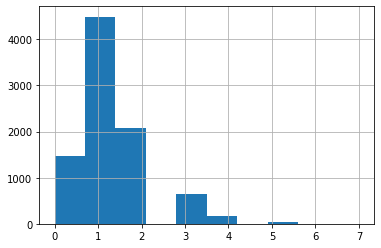

In [237]:
data_control.groupby('user_id')['order_made'].sum().hist()

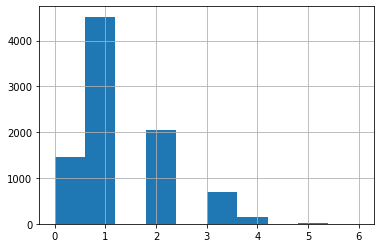

In [238]:
data_test.groupby('user_id')['order_made'].sum().hist()

The distributions are not normal, we cannot use the t-test. Perhaps with the help of the logarithm we can bring it to normal

In [239]:
log_q1=np.log10(q1)
log_q2=np.log10(q2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [241]:
stat, p = shapiro(log_q1)
alpha = 0.05
print('p-value: ', p)
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

p-value:  1.0
Sample looks Gaussian (fail to reject H0)


In [242]:
stat, p = shapiro(log_q2)
alpha = 0.05
print('p-value: ', p)
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

p-value:  1.0
Sample looks Gaussian (fail to reject H0)


The distributions are now normal, let's try a t-test

In [244]:
stats.ttest_ind(log_q1, log_q2)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:4331: RuntimeWarning: invalid value encountered in double_scalars
  d = mean1 - mean2


Ttest_indResult(statistic=nan, pvalue=nan)

And then there is no logarithm of zero, but we have zero in the data. Apparently the t-test won't work

#### Rank test: Mann-Whitney test

In [248]:
q1=data_control.groupby('user_id')['order_made'].sum().to_list()
q2=data_test.groupby('user_id')['order_made'].sum().to_list()

In [249]:
u, p_value = stats.mannwhitneyu(q1, q2)
print("two-sample wilcoxon-test", p_value)

two-sample wilcoxon-test 0.38135112975062313


**P-value > 0.05**, so the control and test groups are **homogeneous** in terms of the "average number of orders per user" metric

#### Bootstrap

In [250]:
clicks_0=np.array(data_control.groupby('user_id')['order_made'].sum())
clicks_1=np.array(data_test.groupby('user_id')['order_made'].sum())

In [251]:
views_0=np.array(data_control.groupby('user_id')['price_seen'].sum())
views_1=np.array(data_test.groupby('user_id')['price_seen'].sum())

In [252]:
weights_0=np.ones((len(clicks_0)))
weights_1=np.ones((len(clicks_1)))
weights_0

array([1., 1., 1., ..., 1., 1., 1.])

In [253]:
def get_smoothed_ctrs(clicks_0, views_0, clicks_1, views_1, smothing_factor=200.):
    """
    Calculates smoothed ctr for every user in every experiment both in treatment and control groups
    Smoothed_ctr = (user_clicks + smothing_factor * global_ctr) / (user_views + smothing_factor)
    :param clicks_0: np.array shape (n_experiments, n_users), clicks of every user from control group in every experiment
    :param views_0: np.array shape (n_experiments, n_users), views of every user from control group in every experiment
    :param clicks_1: np.array shape (n_experiments, n_users), clicks of every user from treatment group in every experiment
    :param views_1: np.array shape (n_experiments, n_users), views of every user from treatment group in every experiment
    :param smothing_factor: float
    :return: (np.array, np.array) shape (n_experiments, n_users), smoothed ctrs for every user in every experiment
    """
    global_ctr = (np.sum(clicks_0) / np.sum(views_0)).reshape(-1, 1)
    ctrs_0 = (clicks_0 + smothing_factor * global_ctr) / (views_0 + smothing_factor)
    ctrs_1 = (clicks_1 + smothing_factor * global_ctr) / (views_1 + smothing_factor)
    return ctrs_0, ctrs_1

In [254]:
ctrs_0, ctrs_1=get_smoothed_ctrs(clicks_0, views_0, clicks_1, views_1, smothing_factor=200.)

In [255]:
def bootstrap(ctrs_0, weights_0, ctrs_1, weights_1, n_bootstrap=2000):
    """
    Does weighted bootstrap and calculates p-value according to the bootstraped distribution
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), weight of every user from control group in every experiment
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), weight of every user from treatment group in every experiment
    :param n_bootstrap: int - for every experiment wi will generate n_bootstrap bootstrap pseudo-samples
    :return: np.array shape (n_experiments), two-sided p-values of weighted bootstrap test in all experimetns
    """
    poisson_bootstraps = scipy.stats.poisson(1).rvs((n_bootstrap, ctrs_0.shape[1])).astype(np.int64)

    values_0 = np.matmul(ctrs_0 * weights_0, poisson_bootstraps.T)
    weights_0 = np.matmul(weights_0, poisson_bootstraps.T)

    values_1 = np.matmul(ctrs_1 * weights_1, poisson_bootstraps.T)
    weights_1 = np.matmul(weights_1, poisson_bootstraps.T)

    deltas = values_1 / weights_1 - values_0 / weights_0

    positions = np.sum(deltas < 0, axis=1)

    return 2 * np.minimum(positions, n_bootstrap - positions) / n_bootstrap

In [256]:
bootstrap(ctrs_0, weights_0, ctrs_1, weights_1, n_bootstrap=2000)

array([0.569])

**P-value > 0.05**, so the result is the same as in the Mann-Whitney test - **samples are homogeneous**.

#### Bucketing

In [257]:
weights_0=np.ones((1,len(clicks_0)))
weights_1=np.ones((1,len(clicks_1)))

In [258]:
def bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=200):
    """
    Does weighted bucketization and calculates p-values for all experiments using t_test
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), weight of every user from control group in every experiment
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), weight of every user from treatment group in every experiment
    :param n_buckets: int, nubmer of buckets
    :return: np.array shape (n_experiments), two-sided p-values of weighted bucketization test in all the experimetns
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int)
        values_0[:, b] = np.sum(ctrs_0[:, ind] * weights_0[:, ind], axis=1) / np.sum(weights_0[:, ind], axis=1)
        values_1[:, b] = np.sum(ctrs_1[:, ind] * weights_1[:, ind], axis=1) / np.sum(weights_1[:, ind], axis=1)

    return np.mean(values_0), np.mean(values_1), t_test(values_0, values_1)

In [259]:
bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=200)

(0.721266637373293, 0.7212912266045107, array([0.59581539]))

**P-value > 0.05**, so the result is the same as in the Mann-Whitney test - **samples are homogeneous**.

sample.bootstrap_test(sample_control, stat='mean', n_iters=100)

### Order from the center => lower user cancellations

**Hypothesis:** if you raise the cost of the order from the center as in the surge period (for example, by 10% more expensive), the average revenue per user will increase (+ secondary metric: conversion to cancellation will not increase), because when ordering from the center, the user is less likely to "change their mind" due to the urgency/importance of the trip.

In [268]:
data=pd.read_csv('new_dataframe.csv')

In [269]:
#conversion to cancellation from the center
a1=data[data['city_center_order']==1][['user_id','order_made', 'user_cancelled']].groupby('user_id').sum()
a1['conversion']=a1['user_cancelled']/a1['order_made']
a1['conversion'].fillna(0,inplace=True)
a=list(a1['conversion'])
mean(a)

0.1172409849976168

In [270]:
#conversion to cancellation not from the center
a1=data[data['city_center_order']==0][['user_id','order_made', 'user_cancelled']].groupby('user_id').sum()
a1['conversion']=a1['user_cancelled']/a1['order_made']
a1['conversion'].fillna(0,inplace=True)
a=list(a1['conversion'])
mean(a)

0.16014277988861342

In [271]:
#leave in the data only those users who made an order from the center
data=data[data['city_center_order']==1]

In [272]:
#how many users stay
data['user_id'].nunique()

22279

In [275]:
#we will divide into control and test not all of our data, but only 50% of them
users=data['user_id'].unique()
users=list(users)
control_1=random.sample(users, int(len(users)/2))
test_1=list(set(users)-set(control))
control=random.sample(control_1, int(len(users)/4))
test=random.sample(test_1, int(len(users)/4))
len(control)

5569

In [276]:
data_control=data[data['user_id'].isin(control)]
data_test=data[data['user_id'].isin(test)]

In [277]:
#look at the number of orders made per user in each group
q1=data_control.groupby('user_id')['city_center_order'].sum().to_list()
q2=data_test.groupby('user_id')['city_center_order'].sum().to_list()

In [278]:
stat, p = shapiro(q1)
alpha = 0.05
print('p-value: ', p)
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

p-value:  0.0
Sample does not look Gaussian (reject H0)


In [279]:
stat, p = shapiro(q2)
alpha = 0.05
print('p-value: ', p)
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

p-value:  0.0
Sample does not look Gaussian (reject H0)


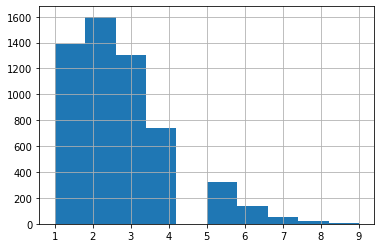

In [280]:
data_control.groupby('user_id')['city_center_order'].sum().hist()

Since the distributions are not normal, we cannot use the student's t-test to compare the means.

#### Mann-Whitney test

In [282]:
u, p_value = stats.mannwhitneyu(q1, q2)
print("two-sample wilcoxon-test", p_value)

two-sample wilcoxon-test 0.18874173746722062


**P-value>0.05**, so the control group and the test group have the same distribution according to the metric "average number of orders NOT from the center per user"

**Baketing and bootstrap** we use to check for homogeneity by the metric **"conversion to order cancellation per user"**

In [283]:
clicks_0=np.array(data_control.groupby('user_id')['user_cancelled'].sum())
clicks_1=np.array(data_test.groupby('user_id')['user_cancelled'].sum())

In [284]:
views_0=np.array(data_control.groupby('user_id')['order_made'].sum())
views_1=np.array(data_test.groupby('user_id')['order_made'].sum())

In [285]:
weights_0=np.ones((len(clicks_0)))
weights_1=np.ones((len(clicks_1)))
weights_0

array([1., 1., 1., ..., 1., 1., 1.])

Get the smoothed cancelled_from_made metric

In [286]:
ctrs_0, ctrs_1=get_smoothed_ctrs(clicks_0, views_0, clicks_1, views_1, smothing_factor=200.)
ctrs_0, ctrs_1

(array([[0.13130411, 0.12698224, 0.13130411, ..., 0.12698224, 0.12511485,
         0.12573118]]),
 array([[0.13130411, 0.13065729, 0.13065729, ..., 0.12698224, 0.12938258,
         0.12511485]]))

Using a bootstrap to evaluate sample homogeneity in terms of conversion to order cancellation

In [287]:
bootstrap(ctrs_0, weights_0, ctrs_1, weights_1, n_bootstrap=2000)

array([0.826])

**P-value > 0.05 means that the samples are homogeneous**

In [288]:
weights_0=np.ones((1,len(clicks_0)))
weights_1=np.ones((1,len(clicks_1)))

In [289]:
bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=200)

(0.12762031938876806, 0.12762718471658607, array([0.88031219]))

Same conclusion after bucketing